In [21]:
import matplotlib.pyplot as plt
import torch
import cv2
from torchvision import transforms
import numpy as np
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weigths = torch.load('yolov7-w6-pose.pt', map_location=device)
model = weigths['model']
_ = model.float().eval()

if torch.cuda.is_available():
    model.half().to(device)

In [46]:
image = cv2.imread('./data/IMG_2869.JPG')
image = letterbox(image, 960, stride=64, auto=True)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))

if torch.cuda.is_available():
    image = image.half().to(device)   
output, _ = model(image)

In [47]:
output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)
with torch.no_grad():
    output = output_to_keypoint(output)
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)

for idx in range(output.shape[0]):
    plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)
    print(output)

[[          0           0      295.46      573.31      184.81      573.16     0.94446      327.23      350.21     0.11084      322.37      340.98   0.0081835      326.75      341.31      0.1496      269.32      342.56     0.43258      315.18      348.63     0.84213      239.53      402.32     0.92667      319.77
       421.58     0.97142      276.15      468.25     0.73247      328.68      517.66     0.94748      346.22      463.95     0.61586      365.14      477.89     0.88565       235.4      578.11     0.97635      291.96      587.43     0.98508      245.22      688.76     0.95854       288.8      703.95      0.9745
       240.57      800.03     0.88088      284.33      826.54     0.90687]]


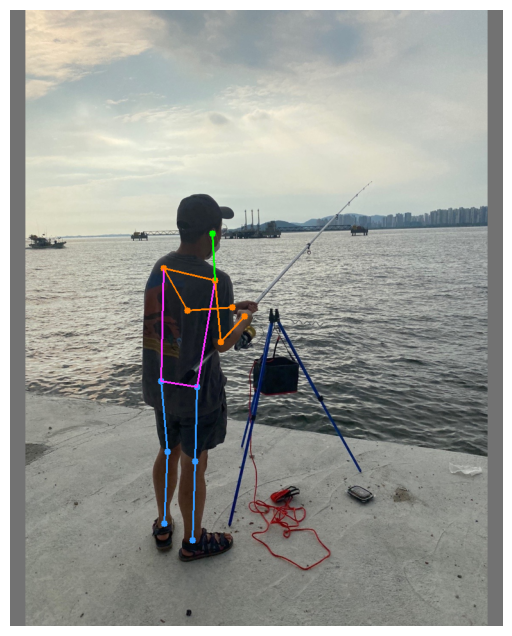

In [31]:
%matplotlib inline
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(nimg)
plt.show()

In [48]:
import glob
import math
import os
import random
from copy import copy
from pathlib import Path

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import yaml
from PIL import Image, ImageDraw, ImageFont
from scipy.signal import butter, filtfilt

from utils.general import xywh2xyxy, xyxy2xywh
from utils.metrics import fitness

In [49]:
# Settings
matplotlib.rc('font', **{'size': 11})
matplotlib.use('Agg')  # for writing to files only

In [50]:
def color_list():
    # Return first 10 plt colors as (r,g,b) https://stackoverflow.com/questions/51350872/python-from-color-name-to-rgb
    def hex2rgb(h):
        return tuple(int(h[1 + i:1 + i + 2], 16) for i in (0, 2, 4))

    return [hex2rgb(h) for h in matplotlib.colors.TABLEAU_COLORS.values()]  # or BASE_ (8), CSS4_ (148), XKCD_ (949)

In [51]:
def hist2d(x, y, n=100):
    # 2d histogram used in labels.png and evolve.png
    xedges, yedges = np.linspace(x.min(), x.max(), n), np.linspace(y.min(), y.max(), n)
    hist, xedges, yedges = np.histogram2d(x, y, (xedges, yedges))
    xidx = np.clip(np.digitize(x, xedges) - 1, 0, hist.shape[0] - 1)
    yidx = np.clip(np.digitize(y, yedges) - 1, 0, hist.shape[1] - 1)
    return np.log(hist[xidx, yidx])


In [52]:
def butter_lowpass_filtfilt(data, cutoff=1500, fs=50000, order=5):
    # https://stackoverflow.com/questions/28536191/how-to-filter-smooth-with-scipy-numpy
    def butter_lowpass(cutoff, fs, order):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        return butter(order, normal_cutoff, btype='low', analog=False)

    b, a = butter_lowpass(cutoff, fs, order=order)
    return filtfilt(b, a, data)  # forward-backward filter

In [53]:
def plot_one_box(x, img, color=None, label=None, line_thickness=3):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

In [63]:
plot_one_box(img = '/Users/iseung-won/yolov7/data/IMG_2869.JPG')

TypeError: plot_one_box() missing 1 required positional argument: 'x'

In [54]:
def plot_one_box_PIL(box, img, color=None, label=None, line_thickness=None):
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    line_thickness = line_thickness or max(int(min(img.size) / 200), 2)
    draw.rectangle(box, width=line_thickness, outline=tuple(color))  # plot
    if label:
        fontsize = max(round(max(img.size) / 40), 12)
        font = ImageFont.truetype("Arial.ttf", fontsize)
        txt_width, txt_height = font.getsize(label)
        draw.rectangle([box[0], box[1] - txt_height + 4, box[0] + txt_width, box[1]], fill=tuple(color))
        draw.text((box[0], box[1] - txt_height + 1), label, fill=(255, 255, 255), font=font)
    return np.asarray(img)

In [55]:
def plot_wh_methods():  # from utils.plots import *; plot_wh_methods()
    # Compares the two methods for width-height anchor multiplication
    # https://github.com/ultralytics/yolov3/issues/168
    x = np.arange(-4.0, 4.0, .1)
    ya = np.exp(x)
    yb = torch.sigmoid(torch.from_numpy(x)).numpy() * 2

    fig = plt.figure(figsize=(6, 3), tight_layout=True)
    plt.plot(x, ya, '.-', label='YOLOv3')
    plt.plot(x, yb ** 2, '.-', label='YOLOR ^2')
    plt.plot(x, yb ** 1.6, '.-', label='YOLOR ^1.6')
    plt.xlim(left=-4, right=4)
    plt.ylim(bottom=0, top=6)
    plt.xlabel('input')
    plt.ylabel('output')
    plt.grid()
    plt.legend()
    fig.savefig('comparison.png', dpi=200)


In [56]:
def output_to_target(output):
    # Convert model output to target format [batch_id, class_id, x, y, w, h, conf]
    targets = []
    for i, o in enumerate(output):
        for *box, conf, cls in o.cpu().numpy():
            targets.append([i, cls, *list(*xyxy2xywh(np.array(box)[None])), conf])
    return np.array(targets)

In [57]:
def plot_images(images, targets, paths=None, fname='images.jpg', names=None, max_size=640, max_subplots=16):
    # Plot image grid with labels

    if isinstance(images, torch.Tensor):
        images = images.cpu().float().numpy()
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().numpy()

    # un-normalise
    if np.max(images[0]) <= 1:
        images *= 255

    tl = 3  # line thickness
    tf = max(tl - 1, 1)  # font thickness
    bs, _, h, w = images.shape  # batch size, _, height, width
    bs = min(bs, max_subplots)  # limit plot images
    ns = np.ceil(bs ** 0.5)  # number of subplots (square)

    # Check if we should resize
    scale_factor = max_size / max(h, w)
    if scale_factor < 1:
        h = math.ceil(scale_factor * h)
        w = math.ceil(scale_factor * w)

    colors = color_list()  # list of colors
    mosaic = np.full((int(ns * h), int(ns * w), 3), 255, dtype=np.uint8)  # init
    for i, img in enumerate(images):
        if i == max_subplots:  # if last batch has fewer images than we expect
            break

        block_x = int(w * (i // ns))
        block_y = int(h * (i % ns))

        img = img.transpose(1, 2, 0)
        if scale_factor < 1:
            img = cv2.resize(img, (w, h))

        mosaic[block_y:block_y + h, block_x:block_x + w, :] = img
        if len(targets) > 0:
            image_targets = targets[targets[:, 0] == i]
            boxes = xywh2xyxy(image_targets[:, 2:6]).T
            classes = image_targets[:, 1].astype('int')
            labels = image_targets.shape[1] == 6  # labels if no conf column
            conf = None if labels else image_targets[:, 6]  # check for confidence presence (label vs pred)

            if boxes.shape[1]:
                if boxes.max() <= 1.01:  # if normalized with tolerance 0.01
                    boxes[[0, 2]] *= w  # scale to pixels
                    boxes[[1, 3]] *= h
                elif scale_factor < 1:  # absolute coords need scale if image scales
                    boxes *= scale_factor
            boxes[[0, 2]] += block_x
            boxes[[1, 3]] += block_y
            for j, box in enumerate(boxes.T):
                cls = int(classes[j])
                color = colors[cls % len(colors)]
                cls = names[cls] if names else cls
                if labels or conf[j] > 0.25:  # 0.25 conf thresh
                    label = '%s' % cls if labels else '%s %.1f' % (cls, conf[j])
                    plot_one_box(box, mosaic, label=label, color=color, line_thickness=tl)

        # Draw image filename labels
        if paths:
            label = Path(paths[i]).name[:40]  # trim to 40 char
            t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
            cv2.putText(mosaic, label, (block_x + 5, block_y + t_size[1] + 5), 0, tl / 3, [220, 220, 220], thickness=tf,
                        lineType=cv2.LINE_AA)

        # Image border
        cv2.rectangle(mosaic, (block_x, block_y), (block_x + w, block_y + h), (255, 255, 255), thickness=3)

    if fname:
        r = min(1280. / max(h, w) / ns, 1.0)  # ratio to limit image size
        mosaic = cv2.resize(mosaic, (int(ns * w * r), int(ns * h * r)), interpolation=cv2.INTER_AREA)
        # cv2.imwrite(fname, cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB))  # cv2 save
        Image.fromarray(mosaic).save(fname)  # PIL save
    return mosaic

In [61]:
plot_images('/Users/iseung-won/yolov7/data/IMG_2869.JPG')

TypeError: plot_images() missing 1 required positional argument: 'targets'

In [58]:
def output_to_keypoint(output):
    # Convert model output to target format [batch_id, class_id, x, y, w, h, conf]
    targets = []
    for i, o in enumerate(output):
        kpts = o[:,6:]
        o = o[:,:6]
        for index, (*box, conf, cls) in enumerate(o.detach().cpu().numpy()):
            targets.append([i, cls, *list(*xyxy2xywh(np.array(box)[None])), conf, *list(kpts.detach().cpu().numpy()[index])])
    return np.array(targets)

In [59]:
def plot_skeleton_kpts(im, kpts, steps, orig_shape=None):
    #Plot the skeleton and keypointsfor coco datatset
    palette = np.array([[255, 128, 0], [255, 153, 51], [255, 178, 102],
                        [230, 230, 0], [255, 153, 255], [153, 204, 255],
                        [255, 102, 255], [255, 51, 255], [102, 178, 255],
                        [51, 153, 255], [255, 153, 153], [255, 102, 102],
                        [255, 51, 51], [153, 255, 153], [102, 255, 102],
                        [51, 255, 51], [0, 255, 0], [0, 0, 255], [255, 0, 0],
                        [255, 255, 255]])

    skeleton = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12],
                [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3],
                [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]

    pose_limb_color = palette[[9, 9, 9, 9, 7, 7, 7, 0, 0, 0, 0, 0, 16, 16, 16, 16, 16, 16, 16]]
    pose_kpt_color = palette[[16, 16, 16, 16, 16, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9]]
    radius = 5
    num_kpts = len(kpts) // steps

    for kid in range(num_kpts):
        r, g, b = pose_kpt_color[kid]
        x_coord, y_coord = kpts[steps * kid], kpts[steps * kid + 1]
        if not (x_coord % 640 == 0 or y_coord % 640 == 0):
            if steps == 3:
                conf = kpts[steps * kid + 2]
                if conf < 0.5:
                    continue
            cv2.circle(im, (int(x_coord), int(y_coord)), radius, (int(r), int(g), int(b)), -1)

    for sk_id, sk in enumerate(skeleton):
        r, g, b = pose_limb_color[sk_id]
        pos1 = (int(kpts[(sk[0]-1)*steps]), int(kpts[(sk[0]-1)*steps+1]))
        pos2 = (int(kpts[(sk[1]-1)*steps]), int(kpts[(sk[1]-1)*steps+1]))
        if steps == 3:
            conf1 = kpts[(sk[0]-1)*steps+2]
            conf2 = kpts[(sk[1]-1)*steps+2]
            if conf1<0.5 or conf2<0.5:
                continue
        if pos1[0]%640 == 0 or pos1[1]%640==0 or pos1[0]<0 or pos1[1]<0:
            continue
        if pos2[0] % 640 == 0 or pos2[1] % 640 == 0 or pos2[0]<0 or pos2[1]<0:
            continue
        cv2.line(im, pos1, pos2, (int(r), int(g), int(b)), thickness=2)

In [60]:
plot_skeleton_kpts('/Users/iseung-won/yolov7/data/IMG_2869.JPG')

TypeError: plot_skeleton_kpts() missing 2 required positional arguments: 'kpts' and 'steps'

In [3]:
import torch
from torchvision import transforms

from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib
matplotlib.use('TkAgg')

In [4]:
def load_model():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = torch.load('/Users/iseung-won/yolov7/yolov7-w6-pose.pt', map_location=device)['model']
    # Put in inference mode
    model.float().eval()

    if torch.cuda.is_available():
        # half() turns predictions into float16 tensors
        # which significantly lowers inference time
        model.half().to(device)
    return model

model = load_model()

In [5]:
def run_inference(url):
    image = cv2.imread(url) # shape: (480, 640, 3)
    # Resize and pad image
    image = letterbox(image, 960, stride=64, auto=True)[0] # shape: (768, 960, 3)
    # Apply transforms
    image = transforms.ToTensor()(image) # torch.Size([3, 768, 960])
    # Turn image into batch
    image = image.unsqueeze(0) # torch.Size([1, 3, 768, 960])
    output, _ = model(image) # torch.Size([1, 45900, 57])
    return output, image

In [6]:
def visualize_output(output, image):
    output = non_max_suppression_kpt(output, 
                                     0.25, # Confidence Threshold
                                     0.65, # IoU Threshold
                                     nc=model.yaml['nc'], # Number of Classes
                                     nkpt=model.yaml['nkpt'], # Number of Keypoints
                                     kpt_label=True)
    with torch.no_grad():
        output = output_to_keypoint(output)
    nimg = image[0].permute(1, 2, 0) * 255
    nimg = nimg.cpu().numpy().astype(np.uint8)
    nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
    for idx in range(output.shape[0]):
        plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(nimg)
    plt.show()

In [7]:
output, image = run_inference('/Users/iseung-won/yolov7/data/IMG_2869.JPG') # Bryan Reyes on Unsplash
visualize_output(output, image)

/Users/iseung-won/opt/anaconda3/envs/yolov7/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


NameError: name 'python' is not defined